In [1]:
%matplotlib inline


컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)
=======================================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_
  **번역**: `박정환 <http://github.com/9bow>`_

이 튜토리얼에서는 전이학습(Transfer Learning)을 이용하여 이미지 분류를 위한
합성곱 신경망을 어떻게 학습시키는지 배워보겠습니다. 전이학습에 대해서는
`CS231n 노트 <http://cs231n.github.io/transfer-learning/>`__ 에서 더 많은 내용을
읽어보실 수 있습니다.

위 노트를 인용해보면,

    실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에,
    (무작위 초기화를 통해) 맨 처음부터 합성곱 신경망(Convolutional
    Network) 전체를 학습하는 사람은 매우 적습니다. 대신, 매우 큰 데이터셋(예.
    100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱
    신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업
    을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용합니다.

이러한 전이학습 시나리오의 주요한 2가지는 다음과 같습니다:

-  **합성곱 신경망의 미세조정(finetuning)**: 무작위 초기화 대신, 신경망을
   ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지
   과정들은 평상시와 같습니다.
-  **고정된 특징 추출기로써의 합성곱 신경망**: 여기서는 마지막에 완전히 연결
   된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된
   계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

데이터 불러오기
---------------

데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용하겠습니다.

여기서 풀고자 하는 문제는 **개미** 와 **벌** 을 분류하는 모델을 학습하는 것입니다.
개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가
있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은
데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을
것입니다.

이 데이터셋은 ImageNet의 아주 작은 일부입니다.

.. Note ::
   데이터를 **[여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)**
   에서 다운로드 받아 현재 디렉토리에 압축을 푸십시오.



In [3]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

일부 이미지 시각화하기
^^^^^^^^^^^^^^^^^^^^^^^^^
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.



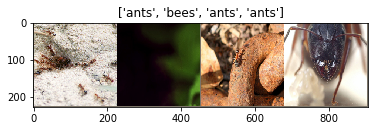

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

모델 학습하기
--------------

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을
설명합니다:

-  학습율(learning rate) 관리(scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러
객체(Object)입니다.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

모델 예측값 시각화하기
^^^^^^^^^^^^^^^^^^^^^^^

일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

합성곱 신경망 미세조정(finetuning)
----------------------------------

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화합니다.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

학습 및 평가하기
^^^^^^^^^^^^^^^^^^

CPU에서는 15-25분 가량, GPU에서는 1분도 이내의 시간이 걸립니다.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6607 Acc: 0.6639
val Loss: 0.2824 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6114 Acc: 0.7418
val Loss: 0.4996 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.5437 Acc: 0.7951
val Loss: 0.5954 Acc: 0.7712

Epoch 3/24
----------
train Loss: 0.7102 Acc: 0.7213
val Loss: 0.2702 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4453 Acc: 0.8115
val Loss: 0.2397 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5086 Acc: 0.7910
val Loss: 0.4863 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.6619 Acc: 0.7664
val Loss: 0.3290 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3694 Acc: 0.8484
val Loss: 0.3183 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.3154 Acc: 0.8770
val Loss: 0.2932 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3282 Acc: 0.8402
val Loss: 0.2606 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3274 Acc: 0.8402
val Loss: 0.2359 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2498 Acc: 0.9057
val Loss: 0.2313 Acc: 0.9150

Ep

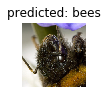

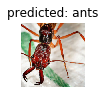

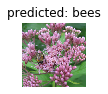

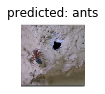

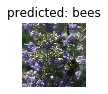

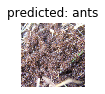

In [10]:
visualize_model(model_ft)

고정된 특징 추출기로써의 합성곱 신경망
---------------------------------------

이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다.
``requires_grad == False`` 로 설정하여 매개변수를 고정하여 ``backward()`` 중에
경사도가 계산되지 않도록 해야합니다.

이에 대한 문서는
`여기 <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__
에서 확인할 수 있습니다.




In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

학습 및 평가하기
^^^^^^^^^^^^^^^^^

CPU에서 실행하는 경우 이전과 비교했을 때 약 절반 가량의 시간만이 소요될 것입니다.
이는 대부분의 신경망에서 경사도를 계산할 필요가 없기 때문입니다. 하지만,
순전파는 계산이 필요합니다.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5569 Acc: 0.7008
val Loss: 0.2164 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4413 Acc: 0.7705
val Loss: 0.1775 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.5897 Acc: 0.7254
val Loss: 0.3163 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.4116 Acc: 0.8156
val Loss: 0.1740 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4141 Acc: 0.8074
val Loss: 0.1625 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3068 Acc: 0.8607
val Loss: 0.1899 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5311 Acc: 0.7951
val Loss: 0.1907 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4282 Acc: 0.8115
val Loss: 0.1899 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2889 Acc: 0.8730
val Loss: 0.1909 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4498 Acc: 0.7951
val Loss: 0.1779 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3614 Acc: 0.8648
val Loss: 0.1620 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.4635 Acc: 0.7992
val Loss: 0.1763 Acc: 0.9608

Ep

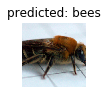

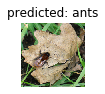

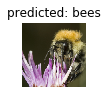

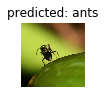

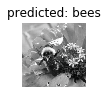

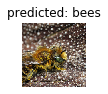

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()